In [111]:
import pandas as pd
import datetime
#import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

#df = web.DataReader("AAPL", 'yahoo', start, end)
#df.tail()
df=pd.read_csv('AAPL.csv')

In [112]:
close_px = df['Adj Close']
mavg = close_px.rolling(10).mean()#calculate the MV of last 10 days.

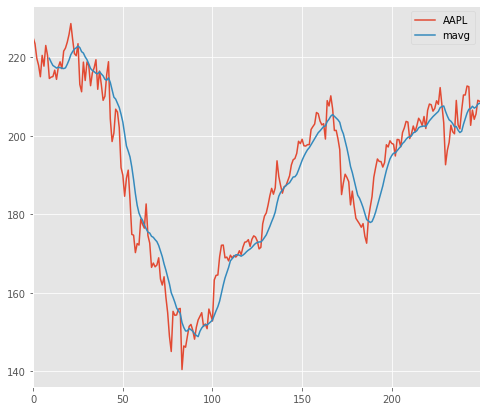

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

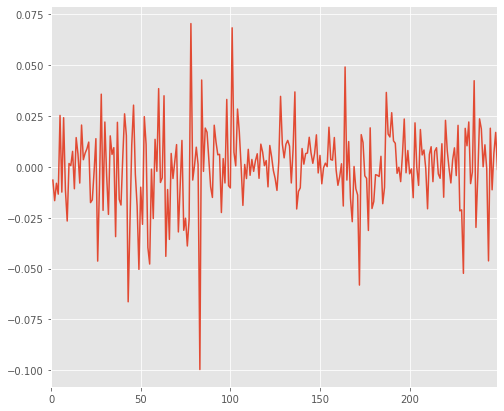

In [114]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [115]:
dfreg=df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

In [116]:
dfreg.tail()

,adj_close,Volume,HL_PCT,PCT_change
245,206.490005,26043600,1.031529,0.306035
246,204.160004,25873300,2.458858,-1.780043
247,205.529999,15938800,1.167710,0.700633
248,209.009995,20990500,1.272668,0.244602
249,208.740005,21143400,1.556961,-0.675675


In [117]:
import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

In [118]:
forecast_out = int(math.ceil(0.05 * len(dfreg)))# Separating the label here, we want to predict the AdjClose
forecast_col = 'adj_close'

In [119]:
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation

In [120]:
dfreg

,adj_close,Volume,HL_PCT,PCT_change,label
0,224.870499,27390100,1.116653,-0.021892,214.334030
1,223.403275,33333000,2.014366,-0.925809,217.416183
2,219.690903,34290000,2.711790,-1.383543,218.794800
3,217.918411,37619800,2.105733,-0.247917,217.051849
4,214.993759,39516500,2.464162,-1.185786,221.512604
...,...,...,...,...,...
245,206.490005,26043600,1.031529,0.306035,NaN
246,204.160004,25873300,2.458858,-1.780043,NaN
247,205.529999,15938800,1.167710,0.700633,NaN
248,209.009995,20990500,1.272668,0.244602,NaN


In [121]:
X = np.array(dfreg.drop(['label'], 1))# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

In [122]:
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

In [123]:
X.shape

(237, 4)

In [124]:
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [125]:
y.shape

(237,)

In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [127]:
# Linear regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [128]:
Linear_pred=clfreg.predict(X_test)

In [129]:
from sklearn.metrics import r2_score, mean_squared_error

ols_mse = mean_squared_error(y_test, Linear_pred)

In [130]:
ols_mse

119.71291422843963

In [131]:
# initialize
ridge_reg = Ridge(alpha=0)
ridge_reg.fit(X_train, y_train)
ridge_df = pd.DataFrame({'variable': dfreg.columns[:-1], 'estimate': ridge_reg.coef_})
ridge_train_pred = []
ridge_test_pred = []

for alpha in np.arange(0, 200, 1):
    # training
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(X_train, y_train)
    var_name = 'estimate' + str(alpha)
    ridge_df[var_name] = ridge_reg.coef_
    # prediction
    ridge_train_pred.append(ridge_reg.predict(X_train))
    ridge_test_pred.append(ridge_reg.predict(X_test))
    
# organize dataframe
ridge_df = ridge_df.set_index('variable').T.rename_axis('estimate').reset_index()

In [132]:
ridge_df

variable,estimate,adj_close,Volume,HL_PCT,PCT_change
0,estimate,15.036293,-3.295972,-1.570079,-0.044989
1,estimate0,15.036293,-3.295972,-1.570079,-0.044989
2,estimate1,14.943764,-3.288607,-1.572542,-0.041288
3,estimate2,14.852391,-3.281232,-1.574892,-0.037635
4,estimate3,14.762151,-3.273848,-1.577133,-0.034031
...,...,...,...,...,...
196,estimate195,6.865167,-2.165044,-1.352711,0.207330
197,estimate196,6.846247,-2.161019,-1.350868,0.207547
198,estimate197,6.827432,-2.157008,-1.349028,0.207760
199,estimate198,6.808722,-2.153012,-1.347190,0.207969


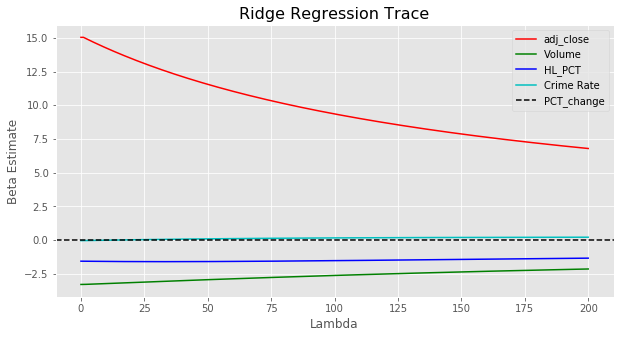

In [133]:
# plot betas by lambda
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ridge_df.adj_close, 'r', ridge_df.Volume, 'g', ridge_df.HL_PCT, 'b', ridge_df.PCT_change, 'c')
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Lambda")
ax.set_ylabel("Beta Estimate")
ax.set_title("Ridge Regression Trace", fontsize=16)
ax.legend(labels=['adj_close','Volume','HL_PCT','Crime Rate','PCT_change'])
ax.grid(True)

Text(0, 0.5, 'MSE')

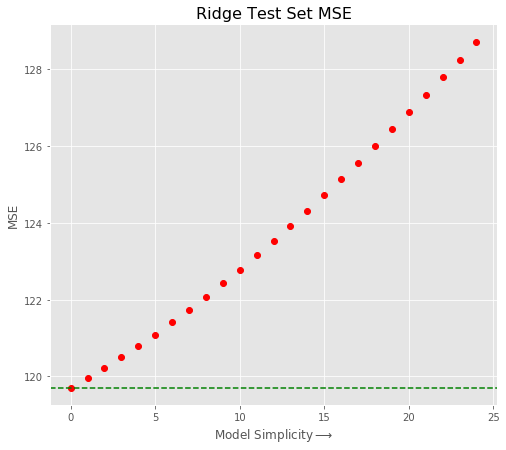

In [134]:
# MSE of Ridge and OLS
ridge_mse_test = [mean_squared_error(y_test, p) for p in ridge_test_pred]
#ols_mse = mean_squared_error(y_test, ols_pred)

# plot mse
plt.plot(ridge_mse_test[:25], 'ro')
plt.axhline(y=ols_mse, color='g', linestyle='--')
plt.title("Ridge Test Set MSE", fontsize=16)
plt.xlabel("Model Simplicity$\longrightarrow$")
plt.ylabel("MSE")

In [135]:
# initialize
ridge_reg = Lasso(alpha=0)
ridge_reg.fit(X_train, y_train)
ridge_df = pd.DataFrame({'variable': dfreg.columns[:-1], 'estimate': ridge_reg.coef_})
ridge_train_pred = []
ridge_test_pred = []

for alpha in np.arange(0, 200, 1):
    # training
    ridge_reg = Lasso(alpha=alpha)
    ridge_reg.fit(X_train, y_train)
    var_name = 'estimate' + str(alpha)
    ridge_df[var_name] = ridge_reg.coef_
    # prediction
    ridge_train_pred.append(ridge_reg.predict(X_train))
    ridge_test_pred.append(ridge_reg.predict(X_test))
    
# organize dataframe
ridge_df = ridge_df.set_index('variable').T.rename_axis('estimate').reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10943.806025025799, tolerance: 6.4671062317989225
  positive)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.

In [136]:
ridge_df

variable,estimate,adj_close,Volume,HL_PCT,PCT_change
0,estimate,15.036293,-3.295972,-1.570079,-0.044989
1,estimate0,15.036293,-3.295972,-1.570079,-0.044989
2,estimate1,14.168920,-2.894013,-0.934923,0.000000
3,estimate2,13.301021,-2.501134,-0.301779,0.000000
4,estimate3,12.438814,-1.899126,-0.000000,0.000000
...,...,...,...,...,...
196,estimate195,0.000000,-0.000000,-0.000000,0.000000
197,estimate196,0.000000,-0.000000,-0.000000,0.000000
198,estimate197,0.000000,-0.000000,-0.000000,0.000000
199,estimate198,0.000000,-0.000000,-0.000000,0.000000


Text(0, 0.5, 'MSE')

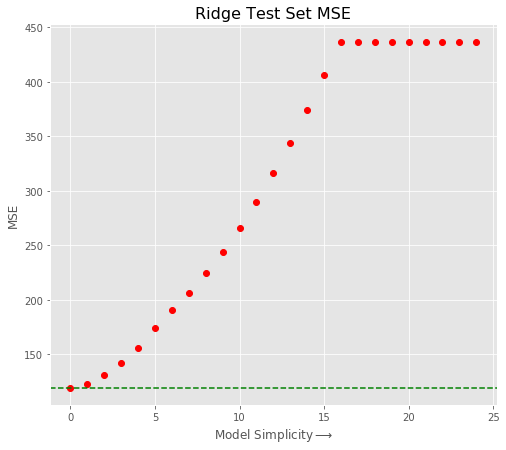

In [137]:
# MSE of Ridge and OLS
ridge_mse_test = [mean_squared_error(y_test, p) for p in ridge_test_pred]
#ols_mse = mean_squared_error(y_test, ols_pred)

# plot mse
plt.plot(ridge_mse_test[:25], 'ro')
plt.axhline(y=ols_mse, color='g', linestyle='--')
plt.title("Ridge Test Set MSE", fontsize=16)
plt.xlabel("Model Simplicity$\longrightarrow$")
plt.ylabel("MSE")

In [138]:
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)
confidencereg2 = clfpoly2.score(X_test, y_test)
poly2pred=clfpoly2.predict(X_test)
poly2_mse = mean_squared_error(y_test, poly2pred)

In [139]:
clfpoly3 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly3.fit(X_train, y_train)
confidencereg3 = clfpoly3.score(X_test, y_test)
poly3pred=clfpoly3.predict(X_test)
poly3_mse = mean_squared_error(y_test, poly3pred)

In [140]:
poly2_mse

118.14708151741965

In [141]:
poly3_mse

118.14708151741965

In [146]:
best_score=np.max([ols_mse,poly2_mse,poly3_mse])

In [147]:
best_score

119.71291422843963

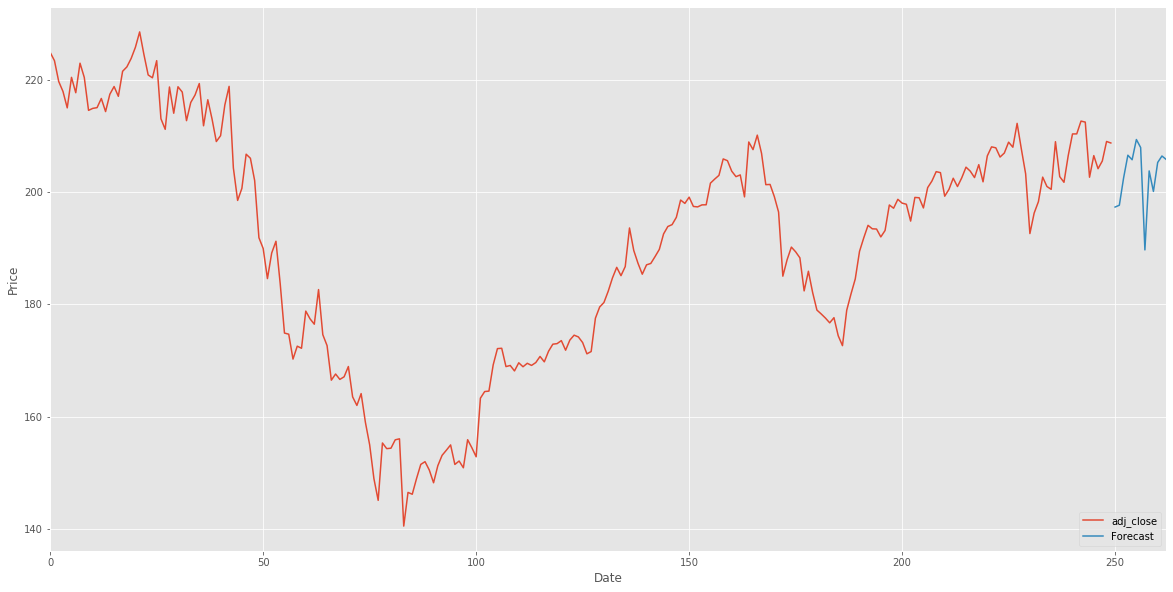

In [142]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan


last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1).days

for i in forecast_set:
    next_date = next_unix
    next_unix =next_unix + int(datetime.timedelta(days=1).days)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
plt.figure(figsize=(20,10))  
dfreg['adj_close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()